In [1]:
# Импорт библиотек
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
# Настройки
pd.set_option('max_columns', 200)
%matplotlib inline

In [3]:
# Глобальные переменные
N_JOBS = 3

## Загрузка данных

In [4]:
features = pd.read_csv('features.zip', index_col='match_id')

features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,1,11,4,3,1058,996,12,0,0,6,42,4,1085,986,12,0,0,4,21,5,2052,1536,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,0,5,39,5,1960,1384,16,0,0,8,88,3,640,566,1,0,1,5,79,3,720,1350,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,0,9,22,5,2305,2028,19,1,1,10,66,3,1024,959,19,0,1,10,86,3,755,620,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,0,6,96,5,1878,1174,17,0,0,6,48,3,732,1468,22,0,0,10,15,4,1681,1051,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,0,8,26,3,704,586,1,0,2,9,69,3,1169,1665,20,1,0,7,22,3,1055,638,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


In [5]:
# Избавляемся от признаков, связанных с итогами матча 
features.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant',
               'barracks_status_dire'], axis = 1, inplace = True)

## Подход 1: градиентный бустинг "в лоб"

#### 1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

In [6]:
print('Признаки, имеющие пропуски в данных:')
null_columns = []
for el in features.isnull().sum()[features.isnull().sum()>0].index:
    null_columns.append(el)
    print('\t', el)

Признаки, имеющие пропуски в данных:
	 first_blood_time
	 first_blood_team
	 first_blood_player1
	 first_blood_player2
	 radiant_bottle_time
	 radiant_courier_time
	 radiant_flying_courier_time
	 radiant_first_ward_time
	 dire_bottle_time
	 dire_courier_time
	 dire_flying_courier_time
	 dire_first_ward_time


- radiant_flying_courier_time: время приобретения предмета "flying_courier". **Пропуск означает, что за первые 5 минут, никто в команде radiant этот предмет не купил**
- dire_bottle_time: время первого приобретения командой предмета "bottle". **Пропуск означает, что за первые 5 минут, никто в команде dire этот предмет не купил**

In [7]:
# Заполняем пропуски в данных нулями
features.fillna(0, inplace=True)

#### 2. Как называется столбец, содержащий целевую переменную?

**radiant_win** - 1, если победила команда Radiant

In [8]:
# матрица объект-признак
X = features.drop('radiant_win', axis = 1)
# целевая переменная
y = features.radiant_win

In [9]:
# Оценим качество алгоритмов при разных n_estimators
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = {}
n_estimators_list = [10, 20, 30, 50, 100, 200]
for n_estimators in n_estimators_list:
    print(f'n_estimators = {n_estimators}')
    clf = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    start_time = datetime.datetime.now()
    model = cross_val_score(clf, X, y, scoring='roc_auc', cv=kfold, n_jobs=N_JOBS)
    finish_time = datetime.datetime.now()
    scores[n_estimators] = {'model': model.mean(), 'time': finish_time - start_time}
    print(f'\tКачество: {scores[n_estimators]["model"]:.3f}, время: {scores[n_estimators]["time"]}')

n_estimators = 10
	Качество: 0.665, время: 0:00:20.451761
n_estimators = 20
	Качество: 0.682, время: 0:00:36.987030
n_estimators = 30
	Качество: 0.690, время: 0:00:56.860518
n_estimators = 50
	Качество: 0.697, время: 0:01:19.396463
n_estimators = 100
	Качество: 0.706, время: 0:02:49.214933
n_estimators = 200
	Качество: 0.714, время: 0:05:34.598371


#### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

In [10]:
print(f"Кросс-валидация для градиентного бустинга с 30 деревьями заняла {scores[30]['time']} секунд")
print(f"Качество по ROC-AUC: {scores[30]['model']:.3f}")

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:00:56.860518 секунд
Качество по ROC-AUC: 0.690


#### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

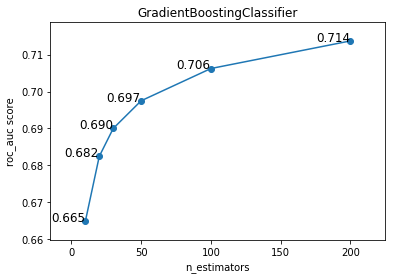

In [14]:
plt.plot(n_estimators_list, [scores[el]['model'] for el in n_estimators_list])
plt.scatter(n_estimators_list, [scores[el]['model'] for el in n_estimators_list])

for el in n_estimators_list:
    plt.text(el-.3, scores[el]['model'], f"{scores[el]['model']:.3f}", fontsize=12, horizontalalignment='right')
    
plt.xlim([min(n_estimators_list)-25, max(n_estimators_list)+25])
plt.ylim([min([scores[el]['model'] for el in n_estimators_list])-0.005,
          max([scores[el]['model'] for el in n_estimators_list])+0.005])
plt.xlabel('n_estimators')
plt.ylabel('roc_auc score')
plt.title('GradientBoostingClassifier')

plt.show()

- Использовать больше 30 деревьев в градиентном бустинге в данной задаче особого имеет смысл, так как качество улучшилось.
- Чтобы ускорить обучение при увеличении числа деревьев можно уменьшить глубину деревьев, можно уменьшить количество фолдов KFold до 3-4. Можно использовать не всю выборку, а только ее часть.

## Подход 2: логистическая регрессия

#### 1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [9]:
# Отскалируем признаки
X_scaled = StandardScaler().fit_transform(X)

In [10]:
# Оценим качество алгоритмов при разных C
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = {}
C_list = [10**i for i in range(-5, 6)]
for C in C_list:
    print(f'C = {C}')
    estimator = LogisticRegression(C=C, random_state=42, n_jobs=-1)
    start_time = datetime.datetime.now()
    model = cross_val_score(estimator, X_scaled, y, scoring='roc_auc', cv=kfold, n_jobs=N_JOBS)
    finish_time = datetime.datetime.now()
    scores[C] = {'model': model.mean(), 'time': finish_time - start_time}
    print(f'\tКачество: {scores[C]["model"]:.3f}, время: {scores[C]["time"]}')

C = 1e-05
	Качество: 0.695, время: 0:00:04.614319
C = 0.0001
	Качество: 0.711, время: 0:00:05.917526
C = 0.001
	Качество: 0.716, время: 0:00:09.825981
C = 0.01
	Качество: 0.717, время: 0:00:11.686011
C = 0.1
	Качество: 0.717, время: 0:00:12.419281
C = 1
	Качество: 0.717, время: 0:00:12.802246
C = 10
	Качество: 0.717, время: 0:00:12.498796
C = 100
	Качество: 0.717, время: 0:00:12.495001
C = 1000
	Качество: 0.717, время: 0:00:12.638110
C = 10000
	Качество: 0.717, время: 0:00:12.558698
C = 100000
	Качество: 0.717, время: 0:00:12.944738


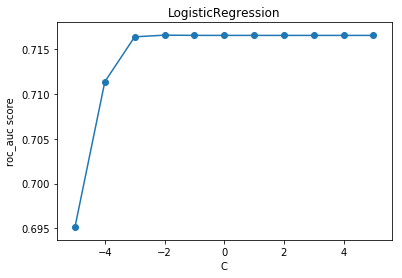

In [11]:
plt.plot(range(-5, 6), [scores[el]['model'] for el in C_list])
plt.scatter(range(-5, 6), [scores[el]['model'] for el in C_list])
    
plt.xlabel('C')
plt.ylabel('roc_auc score')
plt.title('LogisticRegression')

plt.show()

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.717. Это значение сравнимо по качеству с градиентным бустингом по 200 деревьям, при этом логистическая регрессия работает заметно быстрее.

#### 2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

In [10]:
# Отобразим категориальные признаки
cat_cols = []
for col in X.columns:
    if 'hero' in col:
        cat_cols.append(col)
        print(col)
cat_cols.append('lobby_type')
print('lobby_type')

r1_hero
r2_hero
r3_hero
r4_hero
r5_hero
d1_hero
d2_hero
d3_hero
d4_hero
d5_hero
lobby_type


In [11]:
# Отскалируем признаки
X_scaled = StandardScaler().fit_transform(X.drop(cat_cols, axis = 1))

In [14]:
# Оценим качество алгоритмов при разных C
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = {}
C_list = [10**i for i in range(-5, 6)]
for C in C_list:
    print(f'C = {C}')
    estimator = LogisticRegression(C=C, random_state=42, n_jobs=-1)
    start_time = datetime.datetime.now()
    model = cross_val_score(estimator, X_scaled, y, scoring='roc_auc', cv=kfold, n_jobs=N_JOBS)
    finish_time = datetime.datetime.now()
    scores[C] = {'model': model.mean(), 'time': finish_time - start_time}
    print(f'\tКачество: {scores[C]["model"]:.3f}, время: {scores[C]["time"]}')

C = 1e-05
	Качество: 0.695, время: 0:00:04.250866
C = 0.0001
	Качество: 0.711, время: 0:00:05.598987
C = 0.001
	Качество: 0.716, время: 0:00:08.839833
C = 0.01
	Качество: 0.717, время: 0:00:10.752379
C = 0.1
	Качество: 0.717, время: 0:00:11.657254
C = 1
	Качество: 0.717, время: 0:00:12.010064
C = 10
	Качество: 0.717, время: 0:00:12.975322
C = 100
	Качество: 0.717, время: 0:00:12.506416
C = 1000
	Качество: 0.717, время: 0:00:11.754519
C = 10000
	Качество: 0.717, время: 0:00:14.175540
C = 100000
	Качество: 0.717, время: 0:00:13.430847


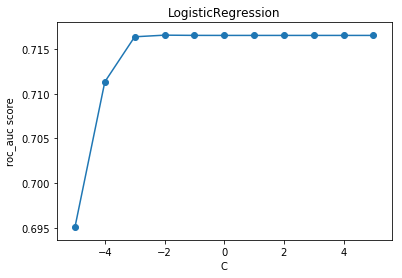

In [15]:
plt.plot(range(-5, 6), [scores[el]['model'] for el in C_list])
plt.scatter(range(-5, 6), [scores[el]['model'] for el in C_list])
    
plt.xlabel('C')
plt.ylabel('roc_auc score')
plt.title('LogisticRegression')

plt.show()

Удаление категориальных признаков не повлияло на качество предсказания. Наилучшее значение показателя AUC-ROC так же достигается при C = 0.01 и равно 0.717. Получается, что в предыдущей модели эти признаки в изначальном своем виде никак не смогли повлиять на результат предсказания.

#### 3. Сколько различных идентификаторов героев существует в данной игре?

In [12]:
nunique = set()
for col in X[cat_cols].drop('lobby_type', axis=1):
    nunique = nunique | set(X[col])
print('Число различных идентификаторов героев:', len(nunique))

Число различных идентификаторов героев: 108


#### 4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

In [13]:
# Создадим мешок слов
X_pick = np.zeros((X.shape[0], max(nunique)))
for i, match_id in enumerate(X.index):
    for p in range(1, 6):
        X_pick[i, X.ix[match_id, f'r{p}_hero']-1] =  1
        X_pick[i, X.ix[match_id, f'd{p}_hero']-1] = -1

X_pick = pd.DataFrame(X_pick, index=X.index)

C:\Users\dac\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [14]:
good_cols = []
print('Столбцы, где все элементы нулевые:')
for col in X_pick:
    if (X_pick[col]==0).all():
        print(f'\t{col}')
    else:
        good_cols.append(col)
print('Избавимся от них')
X_pick = X_pick[good_cols]

Столбцы, где все элементы нулевые:
	23
	106
	107
	110
Избавимся от них


In [15]:
# Добавим мешок слов к матрице объект-признаки (категориальные убираем)
X_bag = pd.concat([X.drop(cat_cols, axis = 1), X_pick], axis=1)

In [16]:
# Отскалируем признаки
X_scaled = StandardScaler().fit_transform(X_bag)

In [21]:
# Оценим качество алгоритмов при разных C
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = {}
C_list = [10**i for i in range(-5, 6)]
for C in C_list:
    print(f'C = {C}')
    estimator = LogisticRegression(C=C, random_state=42, n_jobs=-1)
    start_time = datetime.datetime.now()
    model = cross_val_score(estimator, X_scaled, y, scoring='roc_auc', cv=kfold, n_jobs=N_JOBS)
    finish_time = datetime.datetime.now()
    scores[C] = {'model': model.mean(), 'time': finish_time - start_time}
    print(f'\tКачество: {scores[C]["model"]:.3f}, время: {scores[C]["time"]}')

C = 1e-05
	Качество: 0.715, время: 0:00:08.636404
C = 0.0001
	Качество: 0.743, время: 0:00:09.367897
C = 0.001
	Качество: 0.752, время: 0:00:15.129860
C = 0.01
	Качество: 0.752, время: 0:00:20.634851
C = 0.1
	Качество: 0.752, время: 0:00:22.691868
C = 1
	Качество: 0.752, время: 0:00:21.954556
C = 10
	Качество: 0.752, время: 0:00:20.628254
C = 100
	Качество: 0.752, время: 0:00:20.617092
C = 1000
	Качество: 0.752, время: 0:00:20.556770
C = 10000
	Качество: 0.752, время: 0:00:21.437197
C = 100000
	Качество: 0.752, время: 0:00:25.720081


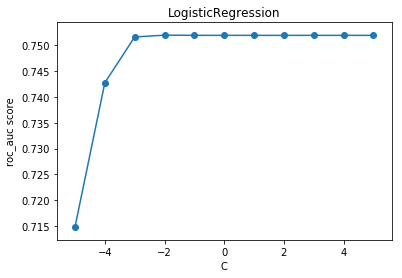

In [22]:
plt.plot(range(-5, 6), [scores[el]['model'] for el in C_list])
plt.scatter(range(-5, 6), [scores[el]['model'] for el in C_list])
    
plt.xlabel('C')
plt.ylabel('roc_auc score')
plt.title('LogisticRegression')

plt.show()

In [23]:
# Наилучший алгоритм:
max([(scores[key]['model'], key) for key in scores])

(0.75196404316175591, 0.01)

После добавления "мешка слов" по героям качество заметно улучшилось. Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.752. Это объясняется тем, что мы правильным образом учли информацию по героям.

#### 5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [17]:
# Обучим лучшую модель на всей обучающей выборке
model = LogisticRegression(C = 0.01, random_state=42)
X_bag = pd.concat([X.drop(cat_cols, axis = 1), X_pick], axis=1)
X_scaled = StandardScaler().fit_transform(X_bag)
model.fit(X_scaled, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
# Загрузим тестовый датасет
test = pd.read_csv('features_test.zip', index_col='match_id')
test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,102,3,1183,963,9,0,2,9,52,5,2289,2043,20,2,0,6,53,3,917,1006,14,0,0,6,57,3,1344,933,3,0,0,9,26,3,1122,949,5,1,0,10,89,4,1847,1866,25,1,0,10,20,3,841,1015,2,1,0,9,29,3,1091,918,6,0,1,8,39,5,1674,1048,12,0,1,7,1.0,0.0,2.0,NaN,72.0,-82.0,NaN,2,2,3,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,6,4,1194,1386,21,0,0,7,65,4,1374,1064,13,0,1,8,92,2,774,737,0,1,0,8,43,5,2254,1787,24,0,0,6,54,3,909,970,16,0,0,5,34,4,1543,929,10,0,0,7,93,4,1485,1389,19,0,0,14,99,3,1075,718,3,0,1,7,5,4,1130,994,1,1,0,10,84.0,1.0,9.0,NaN,138.0,-82.0,233.0,2,6,2,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,26,2,421,569,3,0,0,6,29,3,960,896,3,1,2,6,11,5,1877,1511,23,0,0,8,41,4,1581,1593,26,0,0,4,91,3,687,675,1,0,0,1,22,2,515,793,4,0,0,8,10,3,964,1022,12,0,0,8,49,5,2434,1917,22,0,0,9,54,4,1372,2005,24,2,1,11,168.0,1.0,9.0,NaN,33.0,-88.0,NaN,5,4,3,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,91,2,672,901,6,0,0,8,74,5,2141,1626,28,0,0,7,52,4,1579,2169,28,2,0,7,2,5,1960,1668,27,0,0,8,110,4,1255,704,5,0,1,6,25,2,490,648,1,0,1,9,77,4,1308,1355,22,0,0,7,62,2,536,692,0,1,1,6,49,4,1815,1424,18,0,0,5,55.0,0.0,3.0,NaN,208.0,-78.0,180.0,4,2,2,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,93,5,1703,964,10,0,1,6,30,3,1099,942,2,1,0,6,85,3,1285,1013,10,0,0,8,102,2,484,609,4,0,0,8,14,4,2273,1680,16,1,0,6,64,2,511,541,1,0,0,4,70,4,1135,1399,19,0,0,10,3,3,623,520,1,0,0,10,96,5,1884,1409,15,0,1,11,285.0,1.0,5.0,NaN,225.0,-76.0,NaN,1,3,2,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [19]:
# Заполним пропуски нулями
test.fillna(0, inplace = True)

In [20]:
nunique_test = set()
for col in test[cat_cols].drop('lobby_type', axis=1):
    nunique_test = nunique_test | set(test[col])
print('Число различных идентификаторов героев:', len(nunique_test))

Число различных идентификаторов героев: 108


In [22]:
# Матрица геров
X_pick_test = np.zeros((test.shape[0], max(nunique_test)))
for i, match_id in enumerate(test.index):
    for p in range(1, 6):
        X_pick_test[i, test.ix[match_id, f'r{p}_hero']-1] =  1
        X_pick_test[i, test.ix[match_id, f'd{p}_hero']-1] = -1

X_pick_test = pd.DataFrame(X_pick_test, index=test.index)

C:\Users\dac\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [23]:
good_cols = []
print('Столбцы, где все элементы нулевые:')
for col in X_pick_test:
    if (X_pick_test[col]==0).all():
        print(f'\t{col}')
    else:
        good_cols.append(col)
print('Избавимся от них')
X_pick_test = X_pick_test[good_cols]

Столбцы, где все элементы нулевые:
	23
	106
	107
	110
Избавимся от них


In [24]:
# Матрица объект-признак для тестового датасета
X_bag = pd.concat([test.drop(cat_cols, axis = 1), X_pick_test], axis=1)
X_scaled = StandardScaler().fit_transform(X_bag)

In [28]:
# Запишм предсказания для класса с меткой 1
predict = model.predict_proba(X_scaled)[:,1]

In [38]:
predict_table = pd.DataFrame({'radiant_win': predict}, index = test.index)
predict_table.head()

,radiant_win
match_id,
6,0.822689
7,0.756018
10,0.188658
13,0.856746
16,0.241456


In [39]:
print('Минимальное значение прогноза на тестовой выборке:',  predict_table.radiant_win.min())
print('Максимальное значение прогноза на тестовой выборке:', predict_table.radiant_win.max())

Минимальное значение прогноза на тестовой выборке: 0.00870590076923
Максимальное значение прогноза на тестовой выборке: 0.996328715925


_______